In [49]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

tf.executing_eagerly()

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

from fbprophet import Prophet

print(tf.__version__)

/Users/bryankan/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


2.8.0


## import the data and analyze the miss data

In [235]:
datacsv = pd.read_csv('/Users/bryankan/Code/BUAI445/project/data/The Math Company Project Data Revenue_ADS_v19.csv')

In [236]:
np.set_printoptions(threshold=1e6)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [238]:
datacsv.tail()

week_start  AutotraderInventory_FranchiseDealers_Inventory  AutotraderInventory_IndieDealers_Inventory  AutotraderInventory_TotalDealers_Inventory  BrandMedia_Addressable/Linear_Spends  BrandMedia_ConnectedTV_Spends  BrandMedia_Default_Spends  BrandMedia_Display_Spends  BrandMedia_LiveStreamVideo_Spends  BrandMedia_OOH_Spends  BrandMedia_Radio_Spends  BrandMedia_Social_Spends  BrandMedia_TotalDigitalVideo_Spends  CargurusInventory_AllFranchiseDealers_Inventory  CargurusInventory_AllIndieDealers_Inventory  CargurusInventory_PayingFranchiseDealers_Inventory  CargurusInventory_PayingIndieDealers_Inventory  CargurusInventory_TotalAllDealers_Inventory  CargurusInventory_TotalPayingDealers_Inventory  clientInventory_FranchiseDealers_Inventory  clientInventory_IndieDealers_Inventory  clientInventory_TotalDealers_Inventory  Competitor_CDKGlobal_CostofRevenue  Competitor_CDKGlobal_MarketingandSales  Competitor_CDKGlobal_OperatingExpense  Competitor_CDKGlobal_Revenue  \
260   26-12-22                                             NaN                                         NaN                                         NaN                                   NaN                            NaN                        NaN                        NaN                                NaN                    NaN                      NaN                       NaN                                  NaN                                              NaN                                          NaN                                                NaN                                              NaN                                          NaN                                             NaN                                         NaN                                     NaN                                     NaN                                 NaN                                     NaN                                    NaN                           NaN   
261        NaN                                             NaN                                         NaN                                         NaN                                   NaN                            NaN                        NaN                        NaN                                NaN                    NaN                      NaN                       NaN                                  NaN                                              NaN                                          NaN                                                NaN                                              NaN                                          NaN                                             NaN                                         NaN                                     NaN                                     NaN                                 NaN                                     NaN                                    NaN                           NaN   
262        NaN                                             NaN                                         NaN                                         NaN                                   NaN                            NaN                        NaN                        NaN                                NaN                    NaN                      NaN                       NaN                                  NaN                                              NaN                                          NaN                                                NaN                                              NaN                                          NaN                                             NaN                                         NaN                                     NaN                                     NaN                                 NaN                                     NaN                                    NaN                           NaN   
263        NaN                                             NaN                          

In [240]:
datacsv.describe()

AutotraderInventory_FranchiseDealers_Inventory  AutotraderInventory_IndieDealers_Inventory  AutotraderInventory_TotalDealers_Inventory  BrandMedia_Addressable/Linear_Spends  BrandMedia_ConnectedTV_Spends  BrandMedia_Default_Spends  BrandMedia_Display_Spends  BrandMedia_LiveStreamVideo_Spends  BrandMedia_OOH_Spends  BrandMedia_Radio_Spends  BrandMedia_Social_Spends  BrandMedia_TotalDigitalVideo_Spends  CargurusInventory_AllFranchiseDealers_Inventory  CargurusInventory_AllIndieDealers_Inventory  CargurusInventory_PayingFranchiseDealers_Inventory  CargurusInventory_PayingIndieDealers_Inventory  CargurusInventory_TotalAllDealers_Inventory  CargurusInventory_TotalPayingDealers_Inventory  clientInventory_FranchiseDealers_Inventory  clientInventory_IndieDealers_Inventory  clientInventory_TotalDealers_Inventory  Competitor_CDKGlobal_CostofRevenue  Competitor_CDKGlobal_MarketingandSales  Competitor_CDKGlobal_OperatingExpense  Competitor_CDKGlobal_Revenue  \
count                                      145.000000                                  145.000000                                  145.000000                            183.000000                     183.000000                 183.000000                 183.000000                         183.000000             183.000000               183.000000                183.000000                           183.000000                                       145.000000                                   145.000000                                         145.000000                                       145.000000                                   145.000000                                      145.000000                                  145.000000                              145.000000                              145.000000                        1.830000e+02                                   183.0                                  183.0                  1.830000e+02   
mean                                      3376.455172                                 1967.848276                                 5344.393103                         120174.525491                   55315.747613                 229.802525                5425.044768                        1311.475411            1707.075082              2951.945464               8845.991803                         19607.693968                                      3713.220690                                  4510.510345                                        2535.586207                                      3164.993103                                  8223.917241                                     5700.572414                                 2222.034483                             2222.034483                             4444.179310                        6.420765e+06                                     0.0                                    0.0                  1.251749e+07   
std                                        308.711704                                  209.185037                                  499.430638                         148501.789096                   76236.051281                1106.744277               17508.438785                        5161.819195            5954.604752              8929.325186              14893.999642                         26781.862066                                       344.577911                                   496.078498                                         252.472319                                       319.451668                                   826.545484                                      570.583774                                  213.463515                              213.463515                              426.951657                        1.019030e+07                                     0.0                                    0.0                  1.985880e+07   
min                                        947.000000                                  526.000000                              

In [241]:
datacsv.isna().sum()

week_start                                              4
AutotraderInventory_FranchiseDealers_Inventory        120
AutotraderInventory_IndieDealers_Inventory            120
AutotraderInventory_TotalDealers_Inventory            120
BrandMedia_Addressable/Linear_Spends                   82
BrandMedia_ConnectedTV_Spends                          82
BrandMedia_Default_Spends                              82
BrandMedia_Display_Spends                              82
BrandMedia_LiveStreamVideo_Spends                      82
BrandMedia_OOH_Spends                                  82
BrandMedia_Radio_Spends                                82
BrandMedia_Social_Spends                               82
BrandMedia_TotalDigitalVideo_Spends                    82
CargurusInventory_AllFranchiseDealers_Inventory       120
CargurusInventory_AllIndieDealers_Inventory           120
CargurusInventory_PayingFranchiseDealers_Inventory    120
CargurusInventory_PayingIndieDealers_Inventory        120
CargurusInvent

 ## Q1 Which Marketing channel is most effective?

In [142]:
## datacsv = pd.read_csv('/Users/bryankan/Code/BUAI445/project/data/The Math Company Project Data Revenue_ADS_v19.csv')

In [242]:
PerformanceMedia_Display_Leads_mean = datacsv['PerformanceMedia_Display_Leads'].mean()
datacsv['PerformanceMedia_Display_Leads'] = datacsv['PerformanceMedia_Display_Leads'].fillna(PerformanceMedia_Display_Leads_mean)
PerformanceMedia_Display_Visits_mean = datacsv['PerformanceMedia_Display_Visits'].mean()
datacsv['PerformanceMedia_Display_Visits'] = datacsv['PerformanceMedia_Display_Visits'].fillna(PerformanceMedia_Display_Visits_mean)


In [243]:
datacsv['performanceMediaDisplayEffectiveness'] = datacsv['PerformanceMedia_Display_Leads']/datacsv['PerformanceMedia_Display_Visits']
performanceMediaDisplayEffectivenessAvg = datacsv['performanceMediaDisplayEffectiveness'].mean()
performanceMediaDisplayEffectivenessAvg

0.15055153106535357

In [244]:
PerformanceMedia_PaidSearch_Leads_mean = datacsv['PerformanceMedia_PaidSearch_Leads'].mean()
datacsv['PerformanceMedia_PaidSearch_Leads'] = datacsv['PerformanceMedia_PaidSearch_Leads'].fillna(PerformanceMedia_PaidSearch_Leads_mean)
PerformanceMedia_PaidSearch_Visits_mean = datacsv['PerformanceMedia_PaidSearch_Visits'].mean()
datacsv['PerformanceMedia_PaidSearch_Visits'] = datacsv['PerformanceMedia_PaidSearch_Visits'].fillna(PerformanceMedia_PaidSearch_Visits_mean)


In [245]:
# PerformanceMedia_PaidSearch
datacsv['performanceMediaPaidSearchEffectiveness'] = datacsv['PerformanceMedia_PaidSearch_Leads']/datacsv['PerformanceMedia_PaidSearch_Visits']
performanceMediaPaidSearchEffectivenessAvg = datacsv['performanceMediaPaidSearchEffectiveness'].mean()
performanceMediaPaidSearchEffectivenessAvg


0.14844000100421345

In [246]:
PerformanceMedia_Partner_Leads_mean = datacsv['PerformanceMedia_Partner_Leads'].mean()
datacsv['PerformanceMedia_Partner_Leads'] = datacsv['PerformanceMedia_Partner_Leads'].fillna(PerformanceMedia_Partner_Leads_mean)
PerformanceMedia_Partner_Visits_mean = datacsv['PerformanceMedia_Partner_Visits'].mean()
datacsv['PerformanceMedia_Partner_Visits'] = datacsv['PerformanceMedia_Partner_Visits'].fillna(PerformanceMedia_Partner_Visits_mean)


In [247]:
# PerformanceMedia_Partner
datacsv['performanceMediaPartnerEffectiveness'] = datacsv['PerformanceMedia_Partner_Leads']/datacsv['PerformanceMedia_Partner_Visits']
performanceMediaPartnerEffectivenessAvg = datacsv['performanceMediaPartnerEffectiveness'].mean()
performanceMediaPartnerEffectivenessAvg


0.15163843065928528

In [248]:
NonPaid_Apps_Leads_mean = datacsv['NonPaid_Apps_Leads'].mean()
datacsv['NonPaid_Apps_Leads'] = datacsv['NonPaid_Apps_Leads'].fillna(NonPaid_Apps_Leads_mean)
NonPaid_Apps_Visits_mean = datacsv['NonPaid_Apps_Visits'].mean()
datacsv['NonPaid_Apps_Visits'] = datacsv['NonPaid_Apps_Visits'].fillna(NonPaid_Apps_Visits_mean)

In [249]:
datacsv['nonPaidAppsEffectiveness'] = datacsv['NonPaid_Apps_Leads']/datacsv['NonPaid_Apps_Visits']
nonPaidAppsEffectivenessAvg = datacsv['nonPaidAppsEffectiveness'].mean()
nonPaidAppsEffectivenessAvg

0.020718500772375918

In [250]:
NonPaid_Direct_Leads_mean = datacsv['NonPaid_Direct_Leads'].mean()
datacsv['NonPaid_Direct_Leads'] = datacsv['NonPaid_Direct_Leads'].fillna(NonPaid_Direct_Leads_mean)
NonPaid_Direct_Visits_mean = datacsv['NonPaid_Direct_Visits'].mean()
datacsv['NonPaid_Direct_Visits'] = datacsv['NonPaid_Direct_Visits'].fillna(NonPaid_Direct_Visits_mean)

In [251]:
datacsv['nonPaidDirectEffectiveness'] = datacsv['NonPaid_Direct_Leads']/datacsv['NonPaid_Direct_Visits']
nonPaidDirectEffectivenessAvg = datacsv['nonPaidDirectEffectiveness'].mean()
nonPaidDirectEffectivenessAvg

0.01949470993653927

In [252]:
NonPaid_Email_Leads_mean = datacsv['NonPaid_Email_Leads'].mean()
datacsv['NonPaid_Email_Leads'] = datacsv['NonPaid_Email_Leads'].fillna(NonPaid_Email_Leads_mean)
NonPaid_Email_Visits_mean = datacsv['NonPaid_Email_Visits'].mean()
datacsv['NonPaid_Email_Visits'] = datacsv['NonPaid_Email_Visits'].fillna(NonPaid_Email_Visits_mean)

In [254]:
datacsv['nonPaidEmailEffectiveness'] = datacsv['NonPaid_Email_Leads']/datacsv['NonPaid_Email_Visits']
nonPaidEmailEffectivenessAvg = datacsv['nonPaidEmailEffectiveness'].mean()
nonPaidEmailEffectivenessAvg

0.035707201152116064

In [255]:
NonPaid_OtherProperties_Leads_mean = datacsv['NonPaid_OtherProperties_Leads'].mean()
datacsv['NonPaid_OtherProperties_Leads'] = datacsv['NonPaid_OtherProperties_Leads'].fillna(NonPaid_OtherProperties_Leads_mean)
NonPaid_OtherProperties_Visits_mean = datacsv['NonPaid_OtherProperties_Visits'].mean()
datacsv['NonPaid_OtherProperties_Visits'] = datacsv['NonPaid_OtherProperties_Visits'].fillna(NonPaid_OtherProperties_Visits_mean)

In [256]:
datacsv['nonPaidOtherPropertiesEffectiveness'] = datacsv['NonPaid_OtherProperties_Leads']/datacsv['NonPaid_OtherProperties_Visits']
nonPaidOtherPropertiesEffectivenessAvg = datacsv['nonPaidOtherPropertiesEffectiveness'].mean()
nonPaidOtherPropertiesEffectivenessAvg

0.03585984349551162

In [257]:
NonPaid_SEO_Leads_mean = datacsv['NonPaid_SEO_Leads'].mean()
datacsv['NonPaid_SEO_Leads'] = datacsv['NonPaid_SEO_Leads'].fillna(NonPaid_SEO_Leads_mean)
NonPaid_SEO_Visits_mean = datacsv['NonPaid_SEO_Visits'].mean()
datacsv['NonPaid_SEO_Visits'] = datacsv['NonPaid_SEO_Visits'].fillna(NonPaid_SEO_Visits_mean)

In [258]:
datacsv['nonPaidSEOEffectiveness'] = datacsv['NonPaid_SEO_Leads']/datacsv['NonPaid_SEO_Visits']
nonPaidSEOEffectivenessAvg = datacsv['nonPaidSEOEffectiveness'].mean()
nonPaidSEOEffectivenessAvg

0.010610754861693408

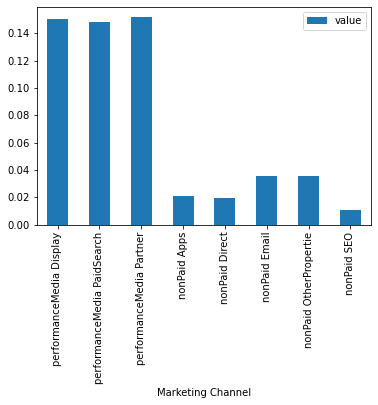

In [261]:
df = pd.DataFrame({'Marketing Channel':['performanceMedia Display', 'performanceMedia PaidSearch', 'performanceMedia Partner', 'nonPaid Apps', 'nonPaid Direct', 'nonPaid Email', 'nonPaid OtherPropertie', 'nonPaid SEO'], 'value':[performanceMediaDisplayEffectivenessAvg, performanceMediaPaidSearchEffectivenessAvg,performanceMediaPartnerEffectivenessAvg, nonPaidAppsEffectivenessAvg, nonPaidDirectEffectivenessAvg, nonPaidEmailEffectivenessAvg, nonPaidOtherPropertiesEffectivenessAvg, nonPaidSEOEffectivenessAvg]})
ax = df.plot.bar(x='Marketing Channel', y='value')


## Q2  What is ROI from each channel?

In [162]:
datacsv = pd.read_csv('/Users/bryankan/Code/BUAI445/project/data/The Math Company Project Data Revenue_ADS_v19.csv')

In [165]:
totalLeads = datacsv['PerformanceMedia_Display_Leads'][:178].sum() + datacsv['PerformanceMedia_PaidSearch_Leads'][:178].sum() + datacsv['PerformanceMedia_Partner_Leads'][:178].sum()
print(totalLeads)


59143858.77717601


In [166]:
# ROI = revenue / spend = revenue of each channel / spend of each channel
# Channel revenue = Total_DeseasonalizedMarketplace_Revenue * weight of each channel
weightMediaDisplay = datacsv['PerformanceMedia_Display_Leads'][:178].sum() / totalLeads
MediaDisplayRevenue = datacsv['Total_DeseasonalizedMarketplace_Revenue'][:178].sum() * weightMediaDisplay
performanceMediaDisplayROI = MediaDisplayRevenue / datacsv['PerformanceMedia_Display_Spends'][:178].sum()
print(performanceMediaDisplayROI)

5.237647428224605


In [167]:
weightMediaPaidSearch = datacsv['PerformanceMedia_PaidSearch_Leads'][:178].sum() / totalLeads
MediaPaidSearchRevenue = datacsv['Total_DeseasonalizedMarketplace_Revenue'][:178].sum() * weightMediaPaidSearch
performanceMediaPaidSearchROI = MediaPaidSearchRevenue / datacsv['PerformanceMedia_PaidSearch_Spends'][:178].sum()
print(performanceMediaPaidSearchROI)

6.358755363534292


In [168]:
weightMediaPartner = datacsv['PerformanceMedia_Partner_Leads'][:178].sum() / totalLeads
MediaPartnerRevenue = datacsv['Total_DeseasonalizedMarketplace_Revenue'][:178].sum() * weightMediaPartner
performanceMediaPartnerROI = MediaPartnerRevenue / datacsv['PerformanceMedia_Partners_Spends'][:178].sum()
print(performanceMediaPartnerROI)

3.406176274842948


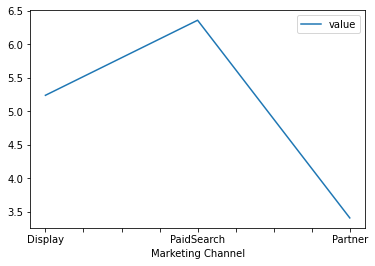

In [170]:
df = pd.DataFrame({'Marketing Channel':['Display', 'PaidSearch', 'Partner'], 'value':[performanceMediaDisplayROI, performanceMediaPaidSearchROI, performanceMediaPartnerROI]})
ax = df.plot.line(x='Marketing Channel', y='value', rot=0)

## Q3 How has the performance of each channel been?

In [171]:
datacsv = pd.read_csv('/Users/bryankan/Code/BUAI445/project/data/The Math Company Project Data Revenue_ADS_v19.csv')

In [172]:
PerformanceMedia_Display_Leads_mean = datacsv['PerformanceMedia_Display_Leads'].mean()
datacsv['PerformanceMedia_Display_Leads'] = datacsv['PerformanceMedia_Display_Leads'].fillna(PerformanceMedia_Display_Leads_mean)
PerformanceMedia_Display_Spends_mean = datacsv['PerformanceMedia_Display_Spends'].mean()
datacsv['PerformanceMedia_Display_Spends'] = datacsv['PerformanceMedia_Display_Spends'].fillna(PerformanceMedia_Display_Spends_mean)


In [174]:
# PerformanceMedia_Display
datacsv['performanceMediaDisplayPerformance'] = datacsv['PerformanceMedia_Display_Spends']/datacsv['PerformanceMedia_Display_Leads']
performanceMediaDisplayPerformanceAvg = datacsv['performanceMediaDisplayPerformance'].mean()
performanceMediaDisplayPerformanceAvg


11.280044856102624

In [175]:
PerformanceMedia_PaidSearch_Spends_mean = datacsv['PerformanceMedia_PaidSearch_Spends'].mean()
datacsv['PerformanceMedia_PaidSearch_Spends'] = datacsv['PerformanceMedia_PaidSearch_Spends'].fillna(PerformanceMedia_PaidSearch_Spends_mean)
PerformanceMedia_PaidSearch_Leads_mean = datacsv['PerformanceMedia_PaidSearch_Leads'].mean()
datacsv['PerformanceMedia_PaidSearch_Leads'] = datacsv['PerformanceMedia_PaidSearch_Leads'].fillna(PerformanceMedia_PaidSearch_Leads_mean)


In [177]:
# PerformanceMedia_PaidSearch
datacsv['performanceMediaPaidSearchPerformance'] = datacsv['PerformanceMedia_PaidSearch_Spends']/datacsv['PerformanceMedia_PaidSearch_Leads']
performanceMediaPaidSearchPerformanceAvg = datacsv['performanceMediaPaidSearchPerformance'].mean()
performanceMediaPaidSearchPerformanceAvg

13.947581774300446

In [178]:
PerformanceMedia_Partners_Spends_mean = datacsv['PerformanceMedia_Partners_Spends'].mean()
datacsv['PerformanceMedia_Partners_Spends'] = datacsv['PerformanceMedia_Partners_Spends'].fillna(PerformanceMedia_Partners_Spends_mean)
PerformanceMedia_Partner_Leads_mean = datacsv['PerformanceMedia_Partner_Leads'].mean()
datacsv['PerformanceMedia_Partner_Leads'] = datacsv['PerformanceMedia_Partner_Leads'].fillna(PerformanceMedia_Partner_Leads_mean)


In [179]:
# PerformanceMedia_Partner
datacsv['performanceMediaPartnerPerformance'] = datacsv['PerformanceMedia_Partners_Spends']/datacsv['PerformanceMedia_Partner_Leads']
performanceMediaPartnerPerformanceAvg = datacsv['performanceMediaPartnerPerformance'].mean()
performanceMediaPartnerPerformanceAvg


11.829266057424173

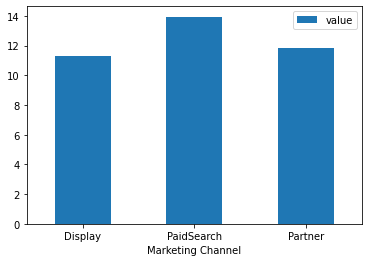

In [262]:
df = pd.DataFrame({'Marketing Channel':['Display', 'PaidSearch', 'Partner'], 'value':[performanceMediaDisplayPerformanceAvg, performanceMediaPaidSearchPerformanceAvg, performanceMediaPartnerPerformanceAvg]})
ax = df.plot.bar(x='Marketing Channel', y='value', rot=0)


## Q5

In [104]:
## 快速测试用
datacsv = pd.read_csv('/Users/bryankan/Code/BUAI445/project/data/The Math Company Project Data Revenue_ADS_v19.csv')

In [108]:
datacsv.isna().sum()

week_start                                            0
AutotraderInventory_FranchiseDealers_Inventory        0
AutotraderInventory_IndieDealers_Inventory            0
AutotraderInventory_TotalDealers_Inventory            0
BrandMedia_Addressable/Linear_Spends                  0
BrandMedia_ConnectedTV_Spends                         0
BrandMedia_Default_Spends                             0
BrandMedia_Display_Spends                             0
BrandMedia_LiveStreamVideo_Spends                     0
BrandMedia_OOH_Spends                                 0
BrandMedia_Radio_Spends                               0
BrandMedia_Social_Spends                              0
BrandMedia_TotalDigitalVideo_Spends                   0
CargurusInventory_AllFranchiseDealers_Inventory       0
CargurusInventory_AllIndieDealers_Inventory           0
CargurusInventory_PayingFranchiseDealers_Inventory    0
CargurusInventory_PayingIndieDealers_Inventory        0
CargurusInventory_TotalAllDealers_Inventory     

In [107]:
datacsv = datacsv.dropna()

In [110]:
datacsv = datacsv.drop('AutotraderInventory_FranchiseDealers_Inventory',axis=1)
datacsv = datacsv.drop('AutotraderInventory_IndieDealers_Inventory',axis=1)
datacsv = datacsv.drop('AutotraderInventory_TotalDealers_Inventory',axis=1)

In [111]:
datacsv.tail()

week_start  BrandMedia_Addressable/Linear_Spends  BrandMedia_ConnectedTV_Spends  BrandMedia_Default_Spends  BrandMedia_Display_Spends  BrandMedia_LiveStreamVideo_Spends  BrandMedia_OOH_Spends  BrandMedia_Radio_Spends  BrandMedia_Social_Spends  BrandMedia_TotalDigitalVideo_Spends  CargurusInventory_AllFranchiseDealers_Inventory  CargurusInventory_AllIndieDealers_Inventory  CargurusInventory_PayingFranchiseDealers_Inventory  CargurusInventory_PayingIndieDealers_Inventory  CargurusInventory_TotalAllDealers_Inventory  CargurusInventory_TotalPayingDealers_Inventory  clientInventory_FranchiseDealers_Inventory  clientInventory_IndieDealers_Inventory  clientInventory_TotalDealers_Inventory  Competitor_CDKGlobal_CostofRevenue  Competitor_CDKGlobal_MarketingandSales  Competitor_CDKGlobal_OperatingExpense  Competitor_CDKGlobal_Revenue  Competitor_CDKWebsite_CostofRevenue  Competitor_CDKWebsite_MarketingandSales  Competitor_CDKWebsite_OperatingExpense  Competitor_CDKWebsite_Revenue  \
174   03-05-21                           33870.96774                    166718.6202                        0.0                        0.0                                0.0            31559.83871              5783.201290               14639.52903                          52476.30943                                           3572.0                                       4053.0                                             2454.0                                           3032.0                                       7625.0                                          5486.0                                      2179.0                                  2179.0                                  4359.0                                 0.0                                     0.0                                    0.0                           0.0                                  0.0                                      0.0                                     0.0                            0.0   
175   10-05-21                           33870.96774                    166718.6202                        0.0                        0.0                                0.0            31559.83871              5783.201290               14639.52903                          52476.30943                                           3572.0                                       4053.0                                             2454.0                                           3032.0                                       7625.0                                          5486.0                                      2179.0                                  2179.0                                  4359.0                                 0.0                                     0.0                                    0.0                           0.0                                  0.0                                      0.0                                     0.0                            0.0   
176   17-05-21                           33870.96774                    166718.6202                        0.0                        0.0                                0.0            31559.83871              5783.201290               14639.52903                          52476.30943                                           3572.0                                       4053.0                                             2454.0                                           3032.0                                       7625.0                                          5486.0                                      2179.0                                  2179.0                                  4359.0                                 0.0                                     0.0                                    0.0                           0.0                                  0.0                                      0.0                                     0.0                            0.0   
177   24-05-21                      

In [78]:
datacsv.pop("week_start")
train_dataset = datacsv.sample(frac=0.8, random_state=0)
test_dataset = datacsv.drop(train_dataset.index)

In [79]:
train_dataset.describe().transpose()

count           mean  \
AutotraderInventory_FranchiseDealers_Inventory   60.0    3409.966667   
AutotraderInventory_IndieDealers_Inventory       60.0    1937.716667   
AutotraderInventory_TotalDealers_Inventory       60.0    5347.683333   
BrandMedia_Addressable/Linear_Spends             60.0   78209.089799   
BrandMedia_ConnectedTV_Spends                    60.0  126633.121557   
...                                               ...            ...   
Total_Total_trend-week                           60.0     141.616667   
Total_Total_trend-year                           60.0       3.300000   
TruecarInventory_FranchiseDealers_Inventory      60.0    1720.016667   
TruecarInventory_IndieDealers_Inventory          60.0     865.933333   
TruecarInventory_TotalDealers_Inventory          60.0    2585.766667   

                                                          std     min  \
AutotraderInventory_FranchiseDealers_Inventory     134.987754  3193.0   
AutotraderInventory_IndieDealers_Inventory         118.190896  1791.0   
AutotraderInventory_TotalDealers_Inventory         231.373093  5063.0   
BrandMedia_Addressable/Linear_Spends            120325.233795     0.0   
BrandMedia_ConnectedTV_Spends                    68198.752849     0.0   
...                                                       ...     ...   
Total_Total_trend-week                              22.265799   105.0   
Total_Total_trend-year                               0.462125     3.0   
TruecarInventory_FranchiseDealers_Inventory        120.976324  1329.0   
TruecarInventory_IndieDealers_Inventory             53.476073   663.0   
TruecarInventory_TotalDealers_Inventory            171.002366  1992.0   

                                                         25%          50%  \
AutotraderInventory_FranchiseDealers_Inventory   3338.250000    3387.0000   
AutotraderInventory_IndieDealers_Inventory       1865.000000    1895.0000   
AutotraderInventory_TotalDealers_Inventory       5189.000000    5299.0000   
BrandMedia_Addressable/Linear_Spends                0.000000   53275.9000   
BrandMedia_ConnectedTV_Spends                   86347.907842  112950.3119   
...                                                      ...          ...   
Total_Total_trend-week                            122.500000     141.0000   
Total_Total_trend-year                              3.000000       3.0000   
TruecarInventory_FranchiseDealers_Inventory      1635.000000    1712.0000   
TruecarInventory_IndieDealers_Inventory           832.000000     852.5000   
TruecarInventory_TotalDealers_Inventory          2470.000000    2567.0000   

                                                        75%          max  
AutotraderInventory_FranchiseDealers_Inventory    3453.0000    3783.0000  
AutotraderInventory_IndieDealers_Inventory        1983.0000    2293.0000  
AutotraderInventory_TotalDealers_Inventory        5419.2500    5950.0000  
BrandMedia_Addressable/Linear_Spends             99630.7900  545620.8710  
BrandMedia_ConnectedTV_Spends                   161166.3087  290491.0478  
...                                                     ...          ...  
Total_Total_trend-week                             160.2500     179.0000  
Total_Total_trend-year                               4.0000       4.0000  
TruecarInventory_FranchiseDealers_Inventory       1780.0000    1994.0000  
TruecarInventory_IndieDealers_Inventory            877.2500     990.0000  
TruecarInventory_TotalDealers_Inventory           2639.0000    2984.0000  

[129 rows x 8 columns]

In [80]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Total_Total_Visits')
test_labels = test_features.pop('Total_Total_Visits')

In [81]:
train_dataset.describe().transpose()[['mean', 'std']]

mean            std
AutotraderInventory_FranchiseDealers_Inventory    3409.966667     134.987754
AutotraderInventory_IndieDealers_Inventory        1937.716667     118.190896
AutotraderInventory_TotalDealers_Inventory        5347.683333     231.373093
BrandMedia_Addressable/Linear_Spends             78209.089799  120325.233795
BrandMedia_ConnectedTV_Spends                   126633.121557   68198.752849
...                                                       ...            ...
Total_Total_trend-week                             141.616667      22.265799
Total_Total_trend-year                               3.300000       0.462125
TruecarInventory_FranchiseDealers_Inventory       1720.016667     120.976324
TruecarInventory_IndieDealers_Inventory            865.933333      53.476073
TruecarInventory_TotalDealers_Inventory           2585.766667     171.002366

[129 rows x 2 columns]

In [82]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [83]:
normalizer.adapt(np.array(train_features))

In [84]:
print(normalizer.mean.numpy())

[[3.40996680e+03 1.93771655e+03 5.34768311e+03 7.82090859e+04
  1.26633117e+05 4.49821899e+02 1.28759678e+04 2.59683765e+03
  3.06773975e+03 6.69660254e+03 1.91836875e+04 4.70344961e+04
  3.73006665e+03 4.49934961e+03 2.51396680e+03 3.12589990e+03
  8.22958301e+03 5.63995020e+03 2.18771655e+03 2.18771655e+03
  4.37556641e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.39318075e+06 5.07321100e+06 8.47197600e+06
  1.19311090e+07 0.00000000e+00 3.70641150e+06 0.00000000e+00
  1.09802290e+07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.59572890e+10 1.11288789e+04 3.64030200e+06
  7.27829688e+04 2.52490675e+06 7.53828047e+04 2.82632200e+06
  1.29565029e+04 2.35758219e+05 5.02678828e+04 9.62830750e+05
  3.90805078e+04 2.47226050e+06 2.48741031e+05 2.34203203e+04
  2.29844578e+05 1.45217050e+06 3.47195273e+04 6.33547000e+05
  1.05068025e+06 1.77650293e+04 2.48058172e+05 1.99801531e+05
  8.3757

In [85]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[3.37e+03 1.90e+03 5.27e+03 6.04e+04 1.09e+05 4.27e-01 9.22e+02 0.00e+00
  0.00e+00 7.36e+03 2.30e+04 5.60e+04 3.57e+03 4.15e+03 2.46e+03 3.02e+03
  7.72e+03 5.47e+03 2.20e+03 2.20e+03 4.40e+03 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.30e+06 5.19e+06 8.69e+06
  1.23e+07 0.00e+00 3.98e+06 0.00e+00 1.17e+07 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 7.47e+10 1.10e+04 3.84e+06 5.71e+04 2.43e+06 5.23e+04 2.53e+06
  9.66e+03 1.92e+05 3.69e+04 8.21e+05 3.05e+04 2.32e+06 3.21e+05 1.85e+04
  2.26e+05 1.37e+06 2.86e+04 6.80e+05 1.03e+06 1.71e+04 2.67e+05 2.02e+05
  9.06e+04 4.10e+05 2.90e+05 1.50e+05 5.94e+06 1.40e+06 1.22e+06 3.58e+04
  1.70e+04 1.85e+04 3.83e+06 2.24e+06 1.57e+06 4.82e+06 1.10e+06 8.61e+03
  2.90e+05 5.92e+06 1.40e+06 1.95e+06 4.31e+05 7.64e+06 1.38e+06 1.89e+05
  4.98e+04 2.64e+04 2.20e+04 0.00e+00 0.00e+00 7.61e+04 3.93e+05 7.60e+04
  3.95e+05 2.17e+04 6.87e+04 1.04e+05 7.81e+03 2.55e+05 0.00e+00 6.45e+03
  0.00e+00 2.94e+00 7.9

In [86]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Total_Total_Visits]')
  plt.legend()
  plt.grid(True)

In [87]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 128)              257       
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,738
Trainable params: 12,481
Non-trainable params: 257
_________________________________________________________________


In [90]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000)

CPU times: user 3min 5s, sys: 26.1 s, total: 3min 31s
Wall time: 2min 55s


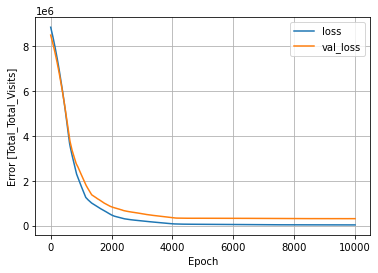

In [91]:
plot_loss(history)

In [92]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)

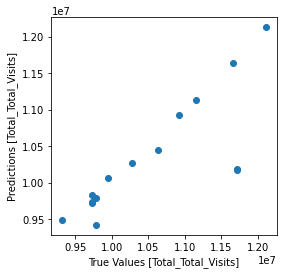

In [93]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Total_Total_Visits]')
plt.ylabel('Predictions [Total_Total_Visits]')
_ = plt.plot()

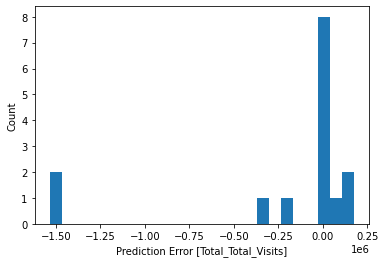

In [94]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Total_Total_Visits]')
_ = plt.ylabel('Count')

In [95]:
dnn_model.save('model')

INFO:tensorflow:Assets written to: dnn_model/assets


#### 新的方法

In [50]:
data2 = pd.read_csv('/Users/bryankan/Code/buai_git_code/445/project/data/data_q5.csv')

In [51]:
data2.isna().sum()

week_start                                 0
BrandMedia_Addressable/Linear_Spends       0
BrandMedia_ConnectedTV_Spends              0
BrandMedia_Default_Spends                  0
BrandMedia_Display_Spends                  0
BrandMedia_LiveStreamVideo_Spends          0
BrandMedia_OOH_Spends                      0
BrandMedia_Radio_Spends                    0
BrandMedia_Social_Spends                   0
BrandMedia_TotalDigitalVideo_Spends        0
NonPaid_Apps_Leads                         4
NonPaid_Apps_Visits                        0
NonPaid_Direct_Leads                       4
NonPaid_Direct_Visits                      0
NonPaid_Email_Leads                        4
NonPaid_Email_Visits                       0
NonPaid_OtherProperties_Leads              4
NonPaid_OtherProperties_Visits             0
NonPaid_SEO_Leads                          4
NonPaid_SEO_Visits                         0
PerformanceMedia_App_Spends                4
PerformanceMedia_Display_Leads             4
Performanc

In [52]:
data2['NonPaid_Apps_Leads'] = data2['NonPaid_Apps_Leads'].fillna(data2['NonPaid_Apps_Leads'].mean())
data2['NonPaid_Direct_Leads'] = data2['NonPaid_Direct_Leads'].fillna(data2['NonPaid_Direct_Leads'].mean())
data2['NonPaid_OtherProperties_Leads'] = data2['NonPaid_OtherProperties_Leads'].fillna(data2['NonPaid_OtherProperties_Leads'].mean())
data2['NonPaid_SEO_Leads'] = data2['NonPaid_SEO_Leads'].fillna(data2['NonPaid_SEO_Leads'].mean())
data2['NonPaid_Email_Leads'] = data2['NonPaid_Email_Leads'].fillna(data2['NonPaid_Email_Leads'].mean())
data2['PerformanceMedia_App_Spends'] = data2['PerformanceMedia_App_Spends'].fillna(data2['PerformanceMedia_App_Spends'].mean())
data2['PerformanceMedia_Display_Leads'] = data2['PerformanceMedia_Display_Leads'].fillna(data2['PerformanceMedia_Display_Leads'].mean())
data2['PerformanceMedia_Display_Spends'] = data2['PerformanceMedia_Display_Spends'].fillna(data2['PerformanceMedia_Display_Spends'].mean())
data2['PerformanceMedia_PaidSearch_Leads'] = data2['PerformanceMedia_PaidSearch_Leads'].fillna(data2['PerformanceMedia_PaidSearch_Leads'].mean())
data2['PerformanceMedia_PaidSearch_Spends'] = data2['PerformanceMedia_PaidSearch_Spends'].fillna(data2['PerformanceMedia_PaidSearch_Spends'].mean())
data2['PerformanceMedia_Partner_Leads'] = data2['PerformanceMedia_Partner_Leads'].fillna(data2['PerformanceMedia_Partner_Leads'].mean())
data2['PerformanceMedia_Partners_Spends'] = data2['PerformanceMedia_Partners_Spends'].fillna(data2['PerformanceMedia_Partners_Spends'].mean())


In [53]:
data2['week_start'] = pd.to_datetime(data2['week_start'])

In [54]:
data2 = data2.sort_values(by = 'week_start')
data2

week_start  BrandMedia_Addressable/Linear_Spends  \
117 1930-03-20                           14063.18710   
17  1930-04-18                          101070.23400   
30  1930-07-18                          356263.75090   
91  1930-09-19                          278906.25000   
152 1930-11-20                          117604.12540   
..         ...                                   ...   
169 2029-03-21                          233837.51610   
69  2029-04-19                          713763.21350   
130 2029-06-20                               0.00000   
82  2029-07-19                           54687.50000   
43  2029-10-18                           59307.15781   

     BrandMedia_ConnectedTV_Spends  BrandMedia_Default_Spends  \
117                     15584.2345                   0.000000   
17                          0.0000                   0.000000   
30                          0.0000                   0.000000   
91                          0.0000                   0.000000   
152                    108745.7144                 182.658312   
..                             ...                        ...   
169                    170587.6224                   0.000000   
69                          0.0000                   0.000000   
130                    269249.8651                   0.000000   
82                          0.0000                   0.000000   
43                          0.0000                   0.000000   

     BrandMedia_Display_Spends  BrandMedia_LiveStreamVideo_Spends  \
117                   0.000000                                0.0   
17                    0.000000                                0.0   
30                    0.000000                                0.0   
91                    0.000000                                0.0   
152                2811.620538                                0.0   
..                         ...                                ...   
169               47996.126430                                0.0   
69                    0.000000                                0.0   
130               13109.028740                                0.0   
82                    0.000000                                0.0   
43                    0.000000                                0.0   

     BrandMedia_OOH_Spends  BrandMedia_Radio_Spends  BrandMedia_Social_Spends  \
117               0.000000                  0.00000                  0.000000   
17                0.000000                  0.00000                  0.000000   
30                0.000000                  0.00000                  0.000000   
91                0.000000                  0.00000                  0.000000   
152               0.000000              13139.60242              29530.327710   
..                     ...                      ...                       ...   
169            3914.709677              16727.67097              29728.954900   
69                0.000000                  0.00000                  0.000000   
130               0.000000                  0.00000               4714.841935   
82                0.000000                  0.00000                  0.000000   
43                0.000000                  0.00000                  0.000000   

     BrandMedia_TotalDigitalVideo_Spends  ...  \
117                          24047.59155  ...   
17                               0.00000  ...   
30                               0.00000  ...   
91                               0.00000  ...   
152                          60891.47345  ...   
..                                   ...  ...   
169                          79335.45470  ...   
69                               0.00000  ...   
130                          38982.38988  ...   
82                               0.00000  ...   
43                               0.00000  ...   

     PerformanceMedia_Display_Visits  PerformanceMedia_PaidSearch_Leads  \
117                     1.187646e+06                        21235.20430   
17       

In [55]:
corrMatrix = data2.corr()

In [56]:
corrMatrix.style.background_gradient(cmap='coolwarm')

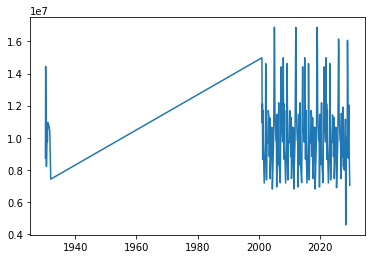

In [57]:
plt.plot(data2['week_start'], data2['Total_Total_Visits'])

In [58]:
indexNames = data2[(data2['week_start'] < '2001-01-01')].index
data2.drop(indexNames , inplace=True)
indexNames = data2[(data2['week_start'] >= '2022-04-18')].index
data2.drop(indexNames , inplace=True)

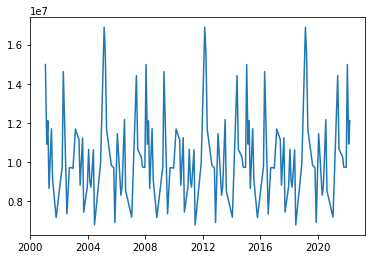

In [59]:
plt.plot(data2['week_start'], data2['Total_Total_Visits'])

In [60]:
data2

week_start  BrandMedia_Addressable/Linear_Spends  \
0   2001-01-18                           167802.8978   
161 2001-02-21                                0.0000   
165 2001-03-21                           545620.8710   
65  2001-04-19                                0.0000   
126 2001-06-20                                0.0000   
..         ...                                   ...   
94  2021-10-19                           278906.2500   
155 2021-12-20                           105673.1516   
3   2022-01-18                           167802.8978   
164 2022-02-21                                0.0000   
168 2022-03-21                           545620.8710   

     BrandMedia_ConnectedTV_Spends  BrandMedia_Default_Spends  \
0                           0.0000                   0.000000   
161                    138649.4578                   0.000000   
165                    212306.3490                   0.000000   
65                          0.0000                   0.000000   
126                    216146.9084                   0.000000   
..                             ...                        ...   
94                          0.0000                   0.000000   
155                    106479.1024                   0.747419   
3                           0.0000                   0.000000   
164                    138649.4578                   0.000000   
168                    212306.3490                   0.000000   

     BrandMedia_Display_Spends  BrandMedia_LiveStreamVideo_Spends  \
0                     0.000000                                0.0   
161                3140.466922                                0.0   
165              111990.961700                                0.0   
65                    0.000000                                0.0   
126                   0.000000                                0.0   
..                         ...                                ...   
94                    0.000000                                0.0   
155                1613.224516                                0.0   
3                     0.000000                                0.0   
164                3140.466922                                0.0   
168              111990.961700                                0.0   

     BrandMedia_OOH_Spends  BrandMedia_Radio_Spends  BrandMedia_Social_Spends  \
0                 0.000000                  0.00000                   0.00000   
161            8230.000000              43208.90000               18159.88000   
165            9134.322581              39031.23226               35511.70677   
65                0.000000                  0.00000                   0.00000   
126               0.000000                  0.00000                   0.00000   
..                     ...                      ...                       ...   
94                0.000000                  0.00000                   0.00000   
155               0.000000              12880.79032               26697.55516   
3                 0.000000                  0.00000                   0.00000   
164            8230.000000              43208.90000               18159.88000   
168            9134.322581              39031.23226               35511.70677   

     BrandMedia_TotalDigitalVideo_Spends  ...  \
0                               0.000000  ...   
161                         48805.933850  ...   
165                         57299.857180  ...   
65                              0.000000  ...   
126                           402.616667  ...   
..                                   ...  ...   
94                              0.000000  ...   
155                         63024.043530  ...   
3                               0.000000  ...   
164                         48805.933850  ...   
168                         57299.857180  ...   

     PerformanceMedia_Display_Visits  PerformanceMedia_PaidSearch_Leads  \
0                       2.207525e+06                       355595.76970   
161      

In [62]:
data2['ds'] = data2['week_start']
data2['y'] = data2['Total_Total_Visits']

In [63]:
model = Prophet() 
model.fit(data2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
future = model.make_future_dataframe(periods=365) 
forecast = model.predict(future) 

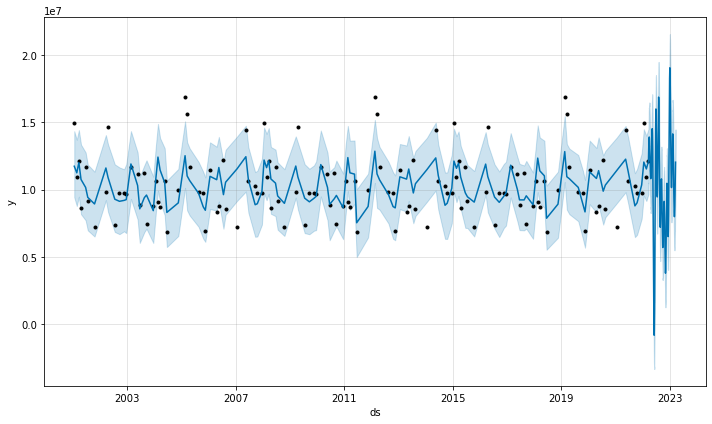

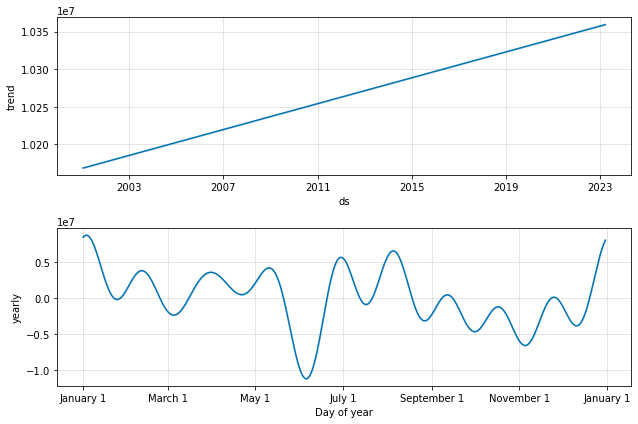

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2001-01-18  1.016845e+07  9.416380e+06  1.433827e+07  1.016845e+07   
1   2001-02-21  1.016925e+07  8.771668e+06  1.370023e+07  1.016925e+07   
2   2001-03-21  1.016991e+07  9.467237e+06  1.442356e+07  1.016991e+07   
3   2001-04-19  1.017060e+07  8.163376e+06  1.333831e+07  1.017060e+07   
4   2001-06-20  1.017206e+07  7.710403e+06  1.276126e+07  1.017206e+07   
..         ...           ...           ...           ...           ...   
489 2023-03-17  1.035922e+07  8.089230e+06  1.293485e+07  1.035922e+07   
490 2023-03-18  1.035924e+07  8.655523e+06  1.344610e+07  1.035924e+07   
491 2023-03-19  1.035927e+07  8.822680e+06  1.394557e+07  1.035927e+07   
492 2023-03-20  1.035929e+07  9.286160e+06  1.416122e+07  1.035929e+07   
493 2023-03-21  1.035931e+07  9.605999e+06  1.447237e+07  1.035931e+07   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    1.016845e+07    1.563360e+06          1.563360e+06          1.563360e+06   
1    1.016925e+07    1.071381e+06          1.071381e+06          1.071381e+06   
2    1.016991e+07    1.835180e+06          1.835180e+06          1.835180e+06   
3    1.017060e+07    5.766508e+05          5.766508e+05          5.766508e+05   
4    1.017206e+07   -1.593716e+04         -1.593716e+04         -1.593716e+04   
..            ...             ...                   ...                   ...   
489  1.035922e+07    2.627221e+05          2.627221e+05          2.627221e+05   
490  1.035924e+07    6.265080e+05          6.265080e+05          6.265080e+05   
491  1.035927e+07    9.863212e+05          9.863212e+05          9.863212e+05   
492  1.035929e+07    1.336942e+06          1.336942e+06          1.336942e+06   
493  1.035931e+07    1.673536e+06          1.673536e+06          1.673536e+06   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    1.563360e+06  1.563360e+06  1.563360e+06                   0.0   
1    1.071381e+06  1.071381e+06  1.071381e+06                   0.0   
2    1.835180e+06  1.835180e+06  1.835180e+06                   0.0   
3    5.766508e+05  5.766508e+05  5.766508e+05                   0.0   
4   -1.593716e+04 -1.593716e+04 -1.593716e+04                   0.0   
..            ...           ...           ...                   ...   
489  2.627221e+05  2.627221e+05  2.627221e+05                   0.0   
490  6.265080e+05  6.265080e+05  6.265080e+05                   0.0   
491  9.863212e+05  9.863212e+05  9.863212e+05                   0.0   
492  1.336942e+06  1.336942e+06  1.336942e+06                   0.0   
493  1.673536e+06  1.673536e+06  1.673536e+06                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                           0.0                         0.0  1.173181e+07  
1                           0.0                         0.0  1.124063e+07  
2                           0.0                         0.0  1.200509e+07  
3                           0.0                         0.0  1.074725e+07  
4                           0.0                         0.0  1.015612e+07  
..                          ...                         ...           ...  
489                         0.0                         0.0  1.062194e+07  
490                         0.0                         0.0  1.098575e+07  
491                         0.0                         0.0  1.134559e+07  
492                         0.0                         0.0  1.169623e+07  
493                         0.0                         0.0  1.203285e+07  

[494 rows x 16 columns]

In [70]:
fig1 = model.plot(forecast) 
fig2 = model.plot_components(forecast) 
plt.show()
forecast

In [66]:
data3 = data2.copy()

In [67]:
data3

week_start  BrandMedia_Addressable/Linear_Spends  \
0   2001-01-18                           167802.8978   
161 2001-02-21                                0.0000   
165 2001-03-21                           545620.8710   
65  2001-04-19                                0.0000   
126 2001-06-20                                0.0000   
..         ...                                   ...   
94  2021-10-19                           278906.2500   
155 2021-12-20                           105673.1516   
3   2022-01-18                           167802.8978   
164 2022-02-21                                0.0000   
168 2022-03-21                           545620.8710   

     BrandMedia_ConnectedTV_Spends  BrandMedia_Default_Spends  \
0                           0.0000                   0.000000   
161                    138649.4578                   0.000000   
165                    212306.3490                   0.000000   
65                          0.0000                   0.000000   
126                    216146.9084                   0.000000   
..                             ...                        ...   
94                          0.0000                   0.000000   
155                    106479.1024                   0.747419   
3                           0.0000                   0.000000   
164                    138649.4578                   0.000000   
168                    212306.3490                   0.000000   

     BrandMedia_Display_Spends  BrandMedia_LiveStreamVideo_Spends  \
0                     0.000000                                0.0   
161                3140.466922                                0.0   
165              111990.961700                                0.0   
65                    0.000000                                0.0   
126                   0.000000                                0.0   
..                         ...                                ...   
94                    0.000000                                0.0   
155                1613.224516                                0.0   
3                     0.000000                                0.0   
164                3140.466922                                0.0   
168              111990.961700                                0.0   

     BrandMedia_OOH_Spends  BrandMedia_Radio_Spends  BrandMedia_Social_Spends  \
0                 0.000000                  0.00000                   0.00000   
161            8230.000000              43208.90000               18159.88000   
165            9134.322581              39031.23226               35511.70677   
65                0.000000                  0.00000                   0.00000   
126               0.000000                  0.00000                   0.00000   
..                     ...                      ...                       ...   
94                0.000000                  0.00000                   0.00000   
155               0.000000              12880.79032               26697.55516   
3                 0.000000                  0.00000                   0.00000   
164            8230.000000              43208.90000               18159.88000   
168            9134.322581              39031.23226               35511.70677   

     BrandMedia_TotalDigitalVideo_Spends  ...  \
0                               0.000000  ...   
161                         48805.933850  ...   
165                         57299.857180  ...   
65                              0.000000  ...   
126                           402.616667  ...   
..                                   ...  ...   
94                              0.000000  ...   
155                         63024.043530  ...   
3                               0.000000  ...   
164                         48805.933850  ...   
168                         57299.857180  ...   

     PerformanceMedia_PaidSearch_Spends  PerformanceMedia_PaidSearch_Visits  \
0                          1.123133e+06                        6.442784e+06   
1

In [68]:
data3['BrandMedia_Addressable/Linear_Spends'] = data3['BrandMedia_Addressable/Linear_Spends']*2
data3['BrandMedia_ConnectedTV_Spends'] = data3['BrandMedia_ConnectedTV_Spends']*2
data3['BrandMedia_Default_Spends'] = data3['BrandMedia_Default_Spends']*2
data3['BrandMedia_Display_Spends'] = data3['BrandMedia_Display_Spends']*2
data3['BrandMedia_LiveStreamVideo_Spends'] = data3['BrandMedia_LiveStreamVideo_Spends']*2
data3['BrandMedia_OOH_Spends'] = data3['BrandMedia_OOH_Spends']*2
data3['BrandMedia_Radio_Spends'] = data3['BrandMedia_Radio_Spends']*2
data3['BrandMedia_Social_Spends'] = data3['BrandMedia_Social_Spends']*2
data3['BrandMedia_TotalDigitalVideo_Spends'] = data3['BrandMedia_TotalDigitalVideo_Spends']*2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


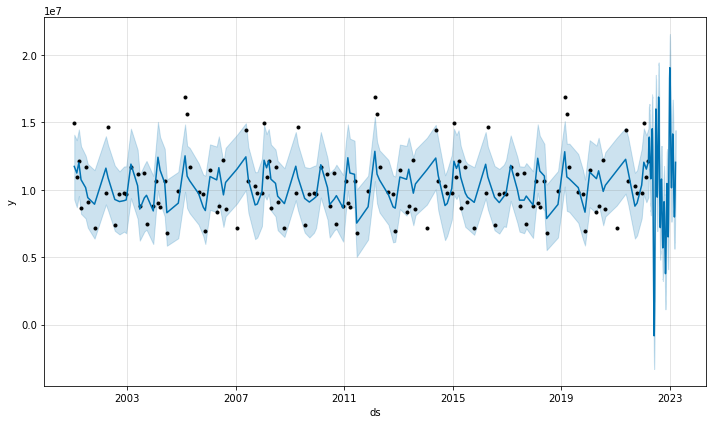

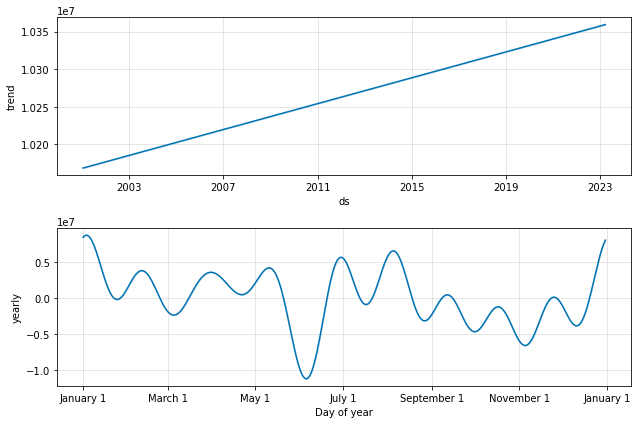

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2001-01-18  1.016845e+07  9.277055e+06  1.408199e+07  1.016845e+07   
1   2001-02-21  1.016925e+07  8.699960e+06  1.367248e+07  1.016925e+07   
2   2001-03-21  1.016991e+07  9.536869e+06  1.447871e+07  1.016991e+07   
3   2001-04-19  1.017060e+07  8.217346e+06  1.323045e+07  1.017060e+07   
4   2001-06-20  1.017206e+07  7.864625e+06  1.253238e+07  1.017206e+07   
..         ...           ...           ...           ...           ...   
489 2023-03-17  1.035922e+07  8.132374e+06  1.312948e+07  1.035922e+07   
490 2023-03-18  1.035924e+07  8.389650e+06  1.332620e+07  1.035924e+07   
491 2023-03-19  1.035927e+07  8.961684e+06  1.395237e+07  1.035927e+07   
492 2023-03-20  1.035929e+07  9.192302e+06  1.433808e+07  1.035929e+07   
493 2023-03-21  1.035931e+07  9.561252e+06  1.442501e+07  1.035931e+07   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    1.016845e+07    1.563360e+06          1.563360e+06          1.563360e+06   
1    1.016925e+07    1.071381e+06          1.071381e+06          1.071381e+06   
2    1.016991e+07    1.835180e+06          1.835180e+06          1.835180e+06   
3    1.017060e+07    5.766508e+05          5.766508e+05          5.766508e+05   
4    1.017206e+07   -1.593716e+04         -1.593716e+04         -1.593716e+04   
..            ...             ...                   ...                   ...   
489  1.035922e+07    2.627221e+05          2.627221e+05          2.627221e+05   
490  1.035924e+07    6.265080e+05          6.265080e+05          6.265080e+05   
491  1.035927e+07    9.863212e+05          9.863212e+05          9.863212e+05   
492  1.035929e+07    1.336942e+06          1.336942e+06          1.336942e+06   
493  1.035931e+07    1.673536e+06          1.673536e+06          1.673536e+06   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    1.563360e+06  1.563360e+06  1.563360e+06                   0.0   
1    1.071381e+06  1.071381e+06  1.071381e+06                   0.0   
2    1.835180e+06  1.835180e+06  1.835180e+06                   0.0   
3    5.766508e+05  5.766508e+05  5.766508e+05                   0.0   
4   -1.593716e+04 -1.593716e+04 -1.593716e+04                   0.0   
..            ...           ...           ...                   ...   
489  2.627221e+05  2.627221e+05  2.627221e+05                   0.0   
490  6.265080e+05  6.265080e+05  6.265080e+05                   0.0   
491  9.863212e+05  9.863212e+05  9.863212e+05                   0.0   
492  1.336942e+06  1.336942e+06  1.336942e+06                   0.0   
493  1.673536e+06  1.673536e+06  1.673536e+06                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                           0.0                         0.0  1.173181e+07  
1                           0.0                         0.0  1.124063e+07  
2                           0.0                         0.0  1.200509e+07  
3                           0.0                         0.0  1.074725e+07  
4                           0.0                         0.0  1.015612e+07  
..                          ...                         ...           ...  
489                         0.0                         0.0  1.062194e+07  
490                         0.0                         0.0  1.098575e+07  
491                         0.0                         0.0  1.134559e+07  
492                         0.0                         0.0  1.169623e+07  
493                         0.0                         0.0  1.203285e+07  

[494 rows x 16 columns]

In [71]:
data3['ds'] = data3['week_start']
data3['y'] = data3['Total_Total_Visits']
model = Prophet() 
model.fit(data3)
future = model.make_future_dataframe(periods=365) 
forecast = model.predict(future) 
fig1 = model.plot(forecast) 
fig2 = model.plot_components(forecast) 
plt.show()
forecast

In [72]:
data4 = data2.copy()

In [73]:
data4

week_start  BrandMedia_Addressable/Linear_Spends  \
0   2001-01-18                           167802.8978   
161 2001-02-21                                0.0000   
165 2001-03-21                           545620.8710   
65  2001-04-19                                0.0000   
126 2001-06-20                                0.0000   
..         ...                                   ...   
94  2021-10-19                           278906.2500   
155 2021-12-20                           105673.1516   
3   2022-01-18                           167802.8978   
164 2022-02-21                                0.0000   
168 2022-03-21                           545620.8710   

     BrandMedia_ConnectedTV_Spends  BrandMedia_Default_Spends  \
0                           0.0000                   0.000000   
161                    138649.4578                   0.000000   
165                    212306.3490                   0.000000   
65                          0.0000                   0.000000   
126                    216146.9084                   0.000000   
..                             ...                        ...   
94                          0.0000                   0.000000   
155                    106479.1024                   0.747419   
3                           0.0000                   0.000000   
164                    138649.4578                   0.000000   
168                    212306.3490                   0.000000   

     BrandMedia_Display_Spends  BrandMedia_LiveStreamVideo_Spends  \
0                     0.000000                                0.0   
161                3140.466922                                0.0   
165              111990.961700                                0.0   
65                    0.000000                                0.0   
126                   0.000000                                0.0   
..                         ...                                ...   
94                    0.000000                                0.0   
155                1613.224516                                0.0   
3                     0.000000                                0.0   
164                3140.466922                                0.0   
168              111990.961700                                0.0   

     BrandMedia_OOH_Spends  BrandMedia_Radio_Spends  BrandMedia_Social_Spends  \
0                 0.000000                  0.00000                   0.00000   
161            8230.000000              43208.90000               18159.88000   
165            9134.322581              39031.23226               35511.70677   
65                0.000000                  0.00000                   0.00000   
126               0.000000                  0.00000                   0.00000   
..                     ...                      ...                       ...   
94                0.000000                  0.00000                   0.00000   
155               0.000000              12880.79032               26697.55516   
3                 0.000000                  0.00000                   0.00000   
164            8230.000000              43208.90000               18159.88000   
168            9134.322581              39031.23226               35511.70677   

     BrandMedia_TotalDigitalVideo_Spends  ...  \
0                               0.000000  ...   
161                         48805.933850  ...   
165                         57299.857180  ...   
65                              0.000000  ...   
126                           402.616667  ...   
..                                   ...  ...   
94                              0.000000  ...   
155                         63024.043530  ...   
3                               0.000000  ...   
164                         48805.933850  ...   
168                         57299.857180  ...   

     PerformanceMedia_PaidSearch_Spends  PerformanceMedia_PaidSearch_Visits  \
0                          1.123133e+06                        6.442784e+06   
1

In [74]:
data3['PerformanceMedia_App_Spends'] = data3['PerformanceMedia_App_Spends']*2
data3['PerformanceMedia_PaidSearch_Spends'] = data3['PerformanceMedia_PaidSearch_Spends']*2
data3['PerformanceMedia_Partners_Spends'] = data3['PerformanceMedia_Partners_Spends']*2
data3['PerformanceMedia_Display_Spends'] = data3['PerformanceMedia_Display_Spends']*2